In [15]:
import os
from pathlib import Path

import pandas as pd
from matplotlib_venn import venn2, venn3
import matplotlib.pyplot as plt


from model_deployment.prove import Summary, StraightLineSummary

from evaluation.eval_analysis import (
    EvalDesc,
    EvalData,
    load_evals,
    find_mutual_proofs,
    PlotPoint,
    ProofPair,
    count_total_successes,
    get_two_eval_subsets,
    get_three_eval_subets,
    a_beats_b_generator,
)

In [16]:
if Path(os.curdir).resolve().name == "evaluation":
    os.chdir("../..")
elif Path(os.curdir).resolve().name == "coq-modeling": 
    pass
else:
    raise ValueError(f"In an unexpected directory: {os.curdir}")
    


In [17]:
EVALS = [
    ## -- Validation --
    # EvalDesc("Proofs + Premises", "deepseek-proof-prem-full-train-500-10min"),
    # EvalDesc("Proofs Only", "deepseek-proof-500"),
    # EvalDesc("Premises Only", "deepseek-prem-500"),
    # EvalDesc("Slurm Basic", "deepseek-slurm-final-500"),
    # EvalDesc("Local Basic", "deepseek-local-final-500"),

    ## -- Testing --
    # EvalDesc("Basic", "deepseek-basic-final-test-500"),
    #EvalDesc("Premises", "deepseek-prem-final-test-500"),
    # EvalDesc("Proofs", "deepseek-proof-final-test-500"),
    # EvalDesc("Proofs (Ted)", "deepseek-tree-proof-final-test-500"),
    # EvalDesc("Proofs (Codebert)", "deepseek-codebert-raw-proof-final"),
    #EvalDesc("Prefix Lines", "deepseek-prefix-final-test-500-retry"),
    #EvalDesc("Proofs + Premises", "deepseek-proof-prem-final-test-500"),


    ## -- Rollouts vs Tree Search --
    # EvalDesc("Beam Branch 4", "deepseek-proof-prem-final-test-500-beam-4"),
    # EvalDesc("Beam Branch 8", "deepseek-proof-prem-final-test-500-beam-8"),
    # EvalDesc("Rand Branch 4", "deepseek-proof-prem-final-test-500-rand-4"),
    # EvalDesc("Rand Branch 8", "deepseek-proof-prem-final-test-500-rand-8"),
    # EvalDesc("Rollouts", "deepseek-proof-prem-final-test-500"),


    ## -- One to one vs Not one to one
    # EvalDesc("Slurm 1:1", "deepseek-slurm-final-1to1-500"),
    # EvalDesc("Slurm 2:1", "deepseek-slurm-final-500"),
    # EvalDesc("Local 2:1", "deepseek-local-final-500"),

    ## -- Random
    # EvalDesc("Basic", "deepseek-basic-random-test-500"),
    # EvalDesc("Premises", "deepseek-prem-random-test-500"),
    # EvalDesc("Proofs", "deepseek-proof-random-test-500"),
    # EvalDesc("Proofs (Ted)", "deepseek-tree-proof-random-test-500"),
    EvalDesc("Proofs (Codebert)", "deepseek-codebert-raw-proof-random"),
    # EvalDesc("Prefix Lines", "deepseek-prefix-random-test-500-retry"),
    # EvalDesc("Proofs + Premises", "deepseek-proof-prem-random-test-500"),

]
RESULTS_LOC = Path("evaluations/eval-results")
raw_evals = load_evals(EVALS, RESULTS_LOC)

## Proof Count (Sanity Check)

In [18]:
mutual_proofs = find_mutual_proofs(raw_evals)
evals = [e.filter_to_proofs(mutual_proofs) for e in raw_evals]
assert all(len(e.results) == len(mutual_proofs) for e in evals)
print("Mutual proofs:", len(mutual_proofs))

Mutual proofs: 500


## Successes

In [19]:
rows: list[tuple[int, int, float]] = []
idx: list[str] = []
for e in evals:
    n_successes = len(e.get_successful_searches())
    n_attempts = len(e.results)
    p = n_successes / n_attempts
    moe = 1.96 * (p * (1 - p) / n_attempts) ** 0.5
    rows.append((n_successes, n_attempts, n_successes / n_attempts))
    idx.append(e.alias)
pd.DataFrame(rows, columns=["Successes", "Attempts", "Success Rate"], index=idx)



,Successes,Attempts,Success Rate
Basic,90,500,0.180
Proofs,143,500,0.286
Proofs (Ted),88,500,0.176
Proofs (Codebert),85,500,0.170


## Count Error Fraction

In [20]:
for e in evals:
    print(e.alias, e.get_error_fraction())

Basic 0.018
Proofs 0.02
Proofs (Ted) 0.008
Proofs (Codebert) 0.008


## Proofs over Time

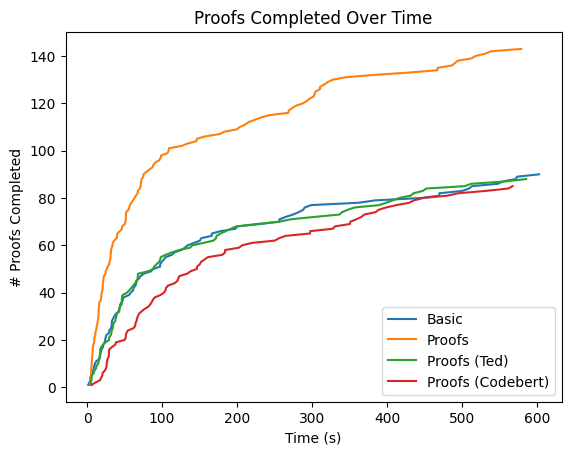

In [21]:
def plot_times(es: list[EvalData]):
    times = [e.get_time_points() for e in es]
    fig, ax = plt.subplots()
    for e, time_list in zip(es, times):
        xs = [t.x for t in time_list]
        ys = [t.y for t in time_list]
        ax.plot(xs, ys, label=e.alias)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("# Proofs Completed")
    ax.set_title("Proofs Completed Over Time")
    ax.legend(loc="lower right")


plot_times(evals)

# Proofs Completed over Model Time

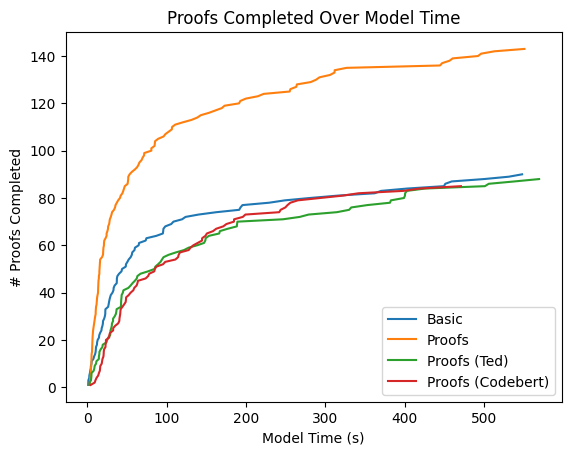

In [22]:
def plot_model_times(es: list[EvalData]):
    times = [e.get_model_time_points() for e in es]
    fig, ax = plt.subplots()
    for e, time_list in zip(es, times):
        xs = [t.x for t in time_list]
        ys = [t.y for t in time_list]
        ax.plot(xs, ys, label=e.alias)
    ax.set_xlabel("Model Time (s)")
    ax.set_ylabel("# Proofs Completed")
    ax.set_title("Proofs Completed Over Model Time")
    ax.legend(loc="lower right")


plot_model_times(evals)

## Proofs over Attempts

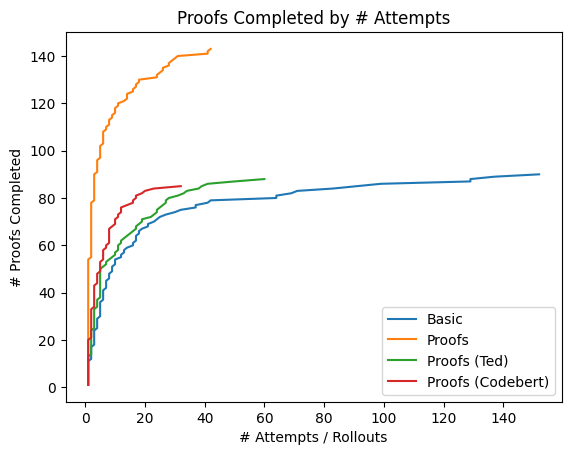

In [23]:
def plot_attempts(es: list[EvalData]):
    attempts = [e.get_attempts_points() for e in es]
    fig, ax = plt.subplots()
    for e, attempt_list in zip(es, attempts):
        xs = [t.x for t in attempt_list]
        ys = [t.y for t in attempt_list]
        ax.plot(xs, ys, label=e.alias)
    ax.set_xlabel("# Attempts / Rollouts")
    ax.set_ylabel("# Proofs Completed")
    ax.set_title("Proofs Completed by # Attempts")
    ax.legend(loc="lower right")


plot_attempts(evals)

## Overlap Comparison

In [24]:
print("Total # Theorems Found: ", count_total_successes(evals))

Total # Theorems Found:  166


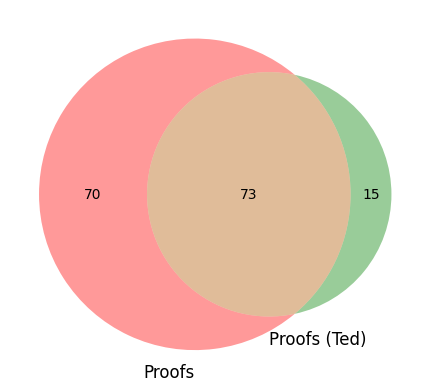

In [25]:
def compare_two(es: list[EvalData], e1_alias: str, e2_alias: str):
    fig, ax = plt.subplots()
    subsets = get_two_eval_subsets(es, e1_alias, e2_alias)
    venn2((len(subsets.one_only), len(subsets.two_only), len(subsets.one_two)),
          set_labels=(e1_alias, e2_alias), ax=ax)


def compare_three(es: list[EvalData], e1_alias: str, e2_alias: str, e3_alias: str):
    fig, ax = plt.subplots()
    subsets = get_three_eval_subets(es, e1_alias, e2_alias, e3_alias)
    venn3((len(subsets.one_only), len(subsets.two_only), len(subsets.one_two),
              len(subsets.three_only), len(subsets.one_three), len(subsets.two_three),
              len(subsets.one_two_three)),
             set_labels=(e1_alias, e2_alias, e3_alias), ax=ax)

compare_two(evals, "Proofs", "Proofs (Ted)")

# Inspect Individual Results

In [26]:
A = "Local Basic"
B = "Slurm Basic"
better_gen = a_beats_b_generator(evals, A, B)

In [27]:
def display_diff(p: ProofPair, e1_alias: str, e2_alias: str, s1: Summary, s2: Summary):
    print(f"{e1_alias} beat {e2_alias} on {p.theorem_name} from {p.file_name}")
    assert s1.success == True
    if isinstance(s1, StraightLineSummary):
        assert s1.attempts is not None
        print(f">>>>> {e1_alias} found a proof in {s1.search_time} seconds ({s1.model_time} model seconds) and {len(s1.attempts)} attempts.")
    else:
        print(f">>>>> {e1_alias} found a proof in {s1.search_time} seconds ({s1.model_time} model seconds)")

    assert s1.proof is not None
    print(s1.proof)

    print()
    if s2.search_time is None:
        print(f"<<<<< {e2_alias} failed with an error.")
        return
    if isinstance(s2, StraightLineSummary):
        assert s2.attempts is not None
        print(f"<<<<< {e2_alias} failed after {s2.search_time} seconds ({s1.model_time} model seconds) and {len(s2.attempts)} attempts.")
        for a in s2.attempts: 
            print(a)
    else:
        print(f"<<<<< {e2_alias} failed after {s2.search_time} seconds ({s1.model_time} model seconds)")


In [28]:
p, s1, s2 = next(better_gen)
display_diff(p, A, B, s1, s2)


AssertionError: 